In [7]:
import os
import librosa
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import CyclicLR
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pickle
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns

def extract_mfcc(data_dir, output_file, n_mfcc=13):
    mfcc_data = []
    labels = []
    genres = sorted(os.listdir(data_dir))

    for genre in genres:
        genre_path = os.path.join(data_dir, genre)
        if not os.path.isdir(genre_path):
            continue
        print(f"Processing genre: {genre}")
        for file in os.listdir(genre_path):
            if file.endswith(".wav"):
                file_path = os.path.join(genre_path, file)
                try:
                    y, sr = librosa.load(file_path, sr=22050)
                    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
                    mfcc_data.append(mfcc.T)
                    labels.append(genre)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

    with open(output_file, "wb") as f:
        pickle.dump((mfcc_data, labels), f)
    print(f"MFCC features saved to {output_file}")

data_dir = "./music_dataset/Data/genres_original"
output_file = "mfcc_features.pkl"
extract_mfcc(data_dir, output_file)

mfcc_file = "mfcc_features.pkl"

class MFCCDataset(Dataset):
    def __init__(self, mfcc_file):
        with open(mfcc_file, "rb") as f:
            self.mfcc_data, self.labels = pickle.load(f)

        genre_counts = {}
        for label in self.labels:
            if label not in genre_counts:
                genre_counts[label] = 0
            genre_counts[label] += 1

        print("Количество треков для каждого жанра:")
        for genre, count in genre_counts.items():
            print(f"{genre}: {count} треков")

        self.encoder = LabelEncoder()
        self.labels = self.encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.mfcc_data)

    def __getitem__(self, idx):
        mfcc = self.mfcc_data[idx]
        label = self.labels[idx]
        mfcc = torch.tensor(mfcc, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return mfcc, label

def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.long)
    return inputs_padded, labels

dataset = MFCCDataset(mfcc_file)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

class LSTMAudioClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, dropout1=0.5, dropout2=0.2):
        super(LSTMAudioClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.gru(x)
        x = x[:, -1, :]
        x = self.dropout1(x)
        x = self.layer_norm(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        return x

input_size = 13
hidden_size = 160
num_classes = len(dataset.encoder.classes_)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Processing genre: blues
Processing genre: classical
Processing genre: country
Processing genre: disco
Processing genre: jazz
Processing genre: metal
Processing genre: pop
Processing genre: reggae
MFCC features saved to mfcc_features.pkl
Количество треков для каждого жанра:
blues: 100 треков
classical: 100 треков
country: 100 треков
disco: 100 треков
jazz: 99 треков
metal: 100 треков
pop: 100 треков
reggae: 100 треков


Epoch 1/130:   Train Loss: 2.1037, Train Accuracy: 11.58%   Test Loss: 2.0816, Test Accuracy: 10.62% 
Epoch 2/130:   Train Loss: 2.0753, Train Accuracy: 14.55%   Test Loss: 2.0337, Test Accuracy: 21.25% 
Epoch 3/130:   Train Loss: 2.0454, Train Accuracy: 18.94%   Test Loss: 1.9053, Test Accuracy: 28.75% 
Epoch 4/130:   Train Loss: 1.9655, Train Accuracy: 24.88%   Test Loss: 1.6763, Test Accuracy: 37.50% 
Epoch 5/130:   Train Loss: 1.7944, Train Accuracy: 33.96%   Test Loss: 1.6281, Test Accuracy: 39.38% 
Epoch 6/130:   Train Loss: 1.5619, Train Accuracy: 37.72%   Test Loss: 1.3889, Test Accuracy: 46.88% 
Epoch 7/130:   Train Loss: 1.4152, Train Accuracy: 45.54%   Test Loss: 1.3580, Test Accuracy: 47.50% 
Epoch 8/130:   Train Loss: 1.3470, Train Accuracy: 50.86%   Test Loss: 1.2338, Test Accuracy: 54.38% 
Epoch 9/130:   Train Loss: 1.2106, Train Accuracy: 53.52%   Test Loss: 1.1346, Test Accuracy: 53.75% 
Epoch 10/130:   Train Loss: 1.1550, Train Accuracy: 55.71%   Test Loss: 1.0928, Te

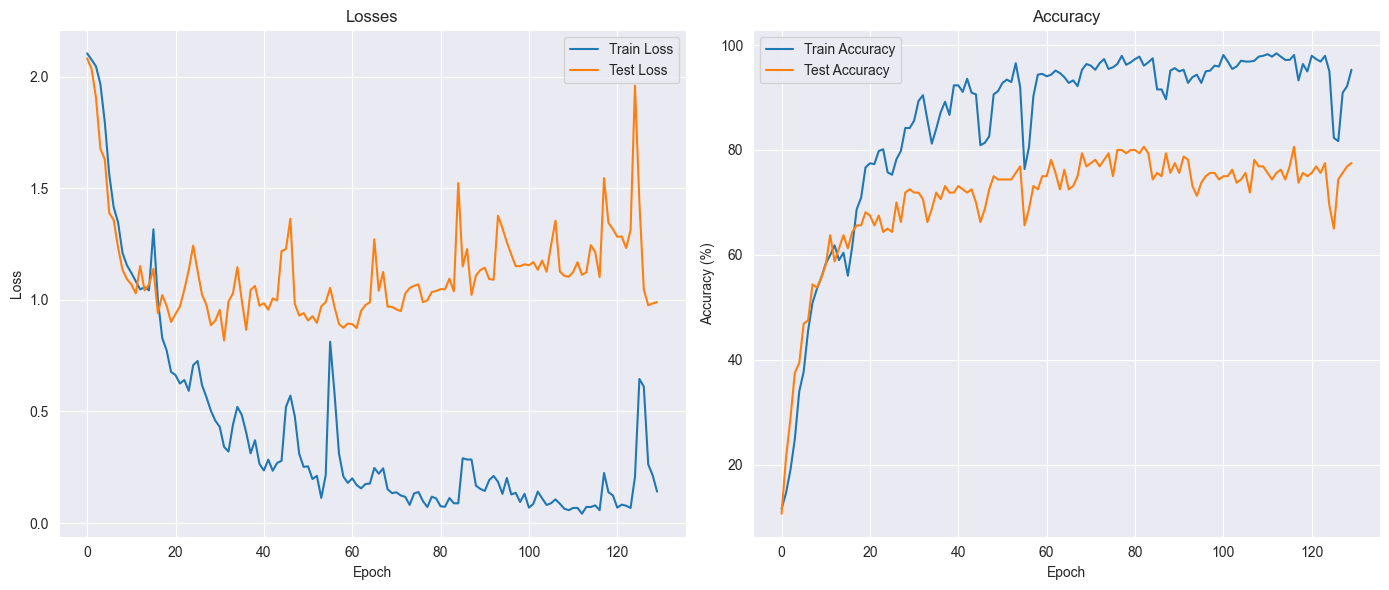

Train Accuracy: 99.22%


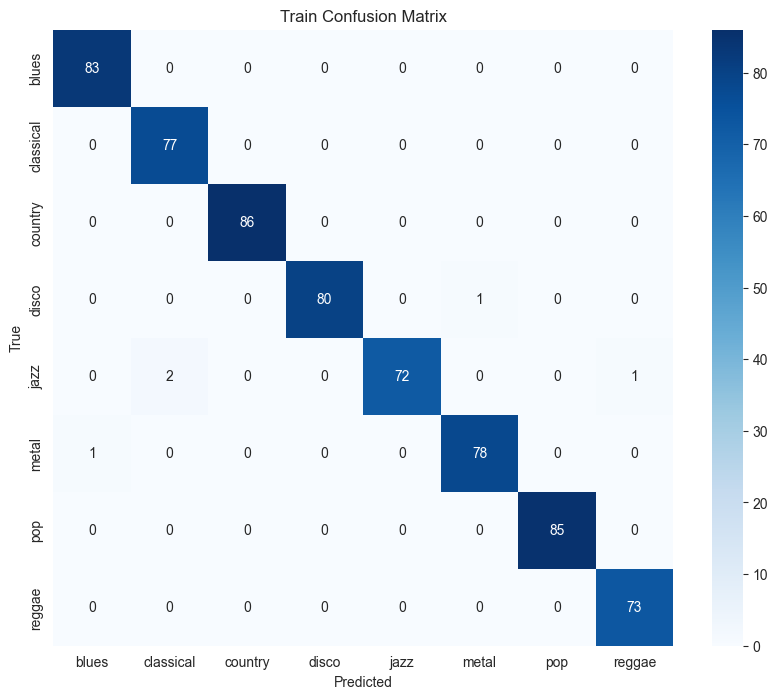

Test Accuracy: 77.50%


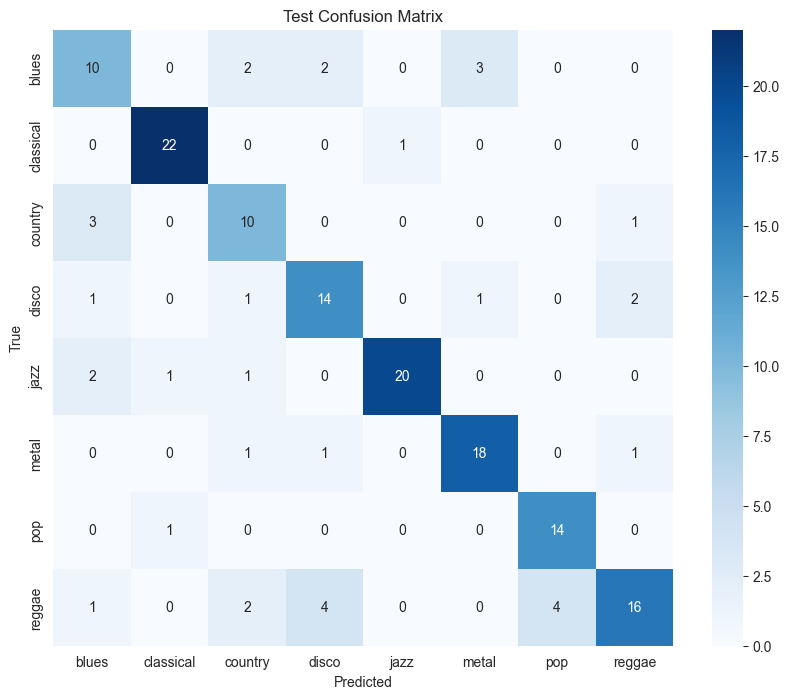

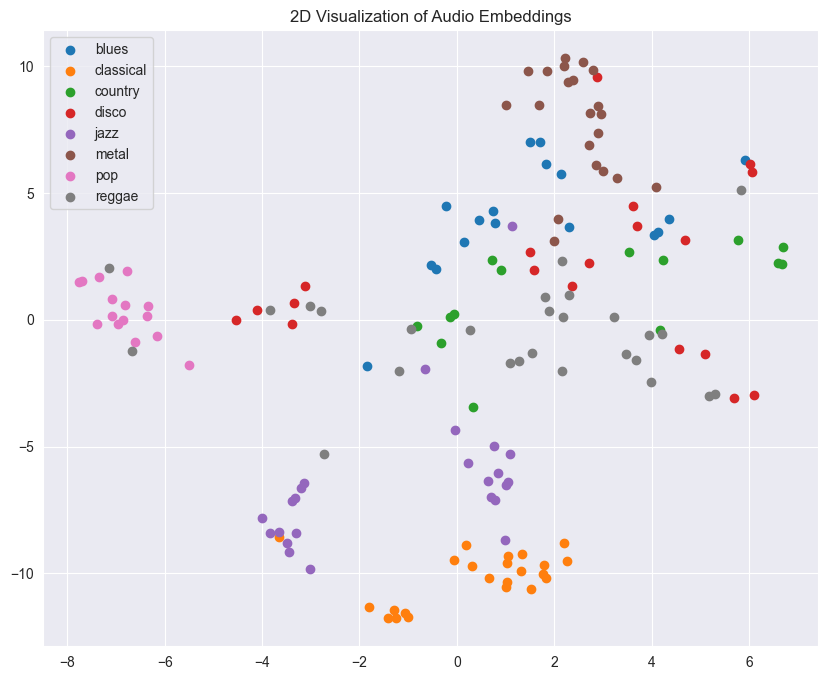

In [10]:
model = LSTMAudioClassifier(input_size, hidden_size, num_classes).to(device)

def train_model(model, train_loader, test_loader, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=9e-5)

    scheduler = CyclicLR(optimizer, base_lr=learning_rate, max_lr=learning_rate * 40, step_size_up=100,
                         mode='triangular')

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            scheduler.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= train_total
        train_accuracy = 100 * train_correct / train_total

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_loss /= test_total
        test_accuracy = 100 * test_correct / test_total

        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(
            f"Epoch {epoch + 1}/{epochs}: "
            f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% "
            f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}% "
        )

    plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)

def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(test_losses, label='Test Loss')
    axs[0].set_title('Losses')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(train_accuracies, label='Train Accuracy')
    axs[1].plot(test_accuracies, label='Test Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

train_model(model, train_loader, test_loader, epochs=130, learning_rate=0.00003)

def evaluate_model(model, loader, dataset_name="Test"):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"{dataset_name} Accuracy: {accuracy:.2f}%")

    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, dataset_name)

def plot_confusion_matrix(cm, dataset_name="Test"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.encoder.classes_,
                yticklabels=dataset.encoder.classes_)
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

evaluate_model(model, train_loader, dataset_name="Train")
evaluate_model(model, test_loader, dataset_name="Test")

def extract_embeddings(model, loader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for inputs, batch_labels in loader:
            inputs = inputs.to(device)
            x, _ = model.gru(inputs)
            x = x[:, -1, :]
            x = model.layer_norm(x)
            x = model.fc1(x)
            x = model.relu(x)
            embeddings.append(x.cpu().numpy())
            labels.extend(batch_labels.numpy())
    return np.vstack(embeddings), np.array(labels)

embeddings, labels = extract_embeddings(model, test_loader)

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
for genre_id in np.unique(labels):
    idx = np.where(labels == genre_id)
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=dataset.encoder.inverse_transform([genre_id])[0])
plt.legend()
plt.title("2D Visualization of Audio Embeddings")
plt.show()